In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import yaml
from scipy.interpolate import interp2d,RectBivariateSpline

In [3]:
input_filename = 'config8'

with h5py.File(input_filename + '.h5' ,'r') as ff:
#     omega      = ff['final-state/spectrum/omega'][:]/1e9
#     theta      = ff['final-state/spectrum/theta'][:]*1e6
#     spectrum   = ff['final-state/spectrum/spectrum'][:]
    
    K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
    X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    W            = ff['final-state/photon/weight'  ][:]

    P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
#     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
#     We            = ff['final-state/photon/weight'  ][:]


In [4]:
with open( input_filename + '.yml', 'r' ) as stream:
    input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
    
    mode             = input_dict['control']['mode']
    
    
    beam_charge      = float( input_dict['beam']['beam_charge'])
    number_electrons = int( beam_charge / 1.60217653e-19)

#     sampling         = input_dict['control']['sampling']
    sampling = mode
    
    w0               = float(input_dict['laser']['w0'])


In [5]:
print (f'beam charge                              : {beam_charge*1e12:.24} pC')
print (f'number of beam electrons                 : {number_electrons:.4e}')
print ('-'*42)
print (f'{sampling} sampling:')
print (f'max  single photon weight                : {amax(W):.4g}')
print (f'mean single photon weight                : {mean(W):.4g}')
print (f'total photon weight                      : {sum(W):.4g}')
print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
print (f'total macro photon number                : {len(W)}')
print ('-'*42)


beam charge                              : 100.0 pC
number of beam electrons                 : 6.2415e+08
------------------------------------------
full sampling:
max  single photon weight                : 8.9
mean single photon weight                : 8.532
total photon weight                      : 2.48e+06
total photon weight per incident electron: 0.003973
total macro photon number                : 290652
------------------------------------------


In [6]:
# figure(figsize=(10,6))
# pcolormesh(omega.ravel(),theta.ravel(),spectrum.T,rasterized=True,cmap=cm.magma)
# xlim(6,9)
# ylim(0,15)
# colorbar(label='spectrum')

# xlabel(r'$\omega$ (GeV)')
# ylabel(r'$\theta$ ($\mu$rad)')

# savefig('spectrum.pdf')

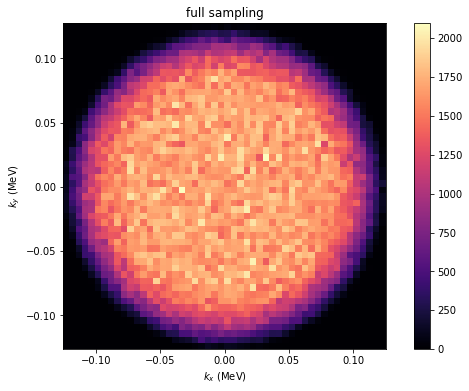

In [7]:
figure(figsize=(10,6))

subplot(111,aspect=1)
hist2d(K1/1e6,K2/1e6,bins=(50,50),weights=W,rasterized=True,cmap=cm.magma);
colorbar()
title(f'{sampling} sampling')

xlabel(r'$k_x$ (MeV)')
ylabel(r'$k_y$ (MeV)')


savefig(f'photon_transverse_momentum_{input_filename}_{mode}.pdf')

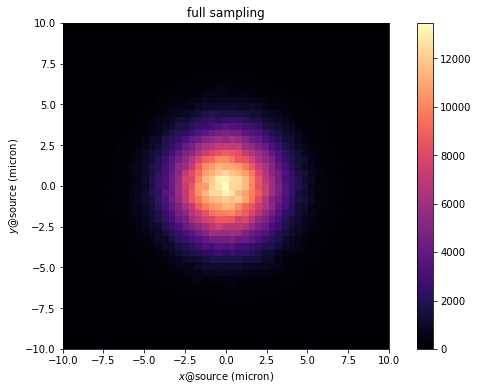

In [8]:
figure(figsize=(10,6))

bbins=(linspace(-2*w0,2*w0,50),linspace(-2*w0,2*w0,50))

subplot(111,aspect=1)
hist2d(X1,X2,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$x@$source (micron)')
ylabel(r'$y@$source (micron)')
title(f'{sampling} sampling')

xlim(-2*w0,2*w0)
ylim(-2*w0,2*w0)


savefig(f'photon_source_size_{input_filename}_{mode}.pdf')


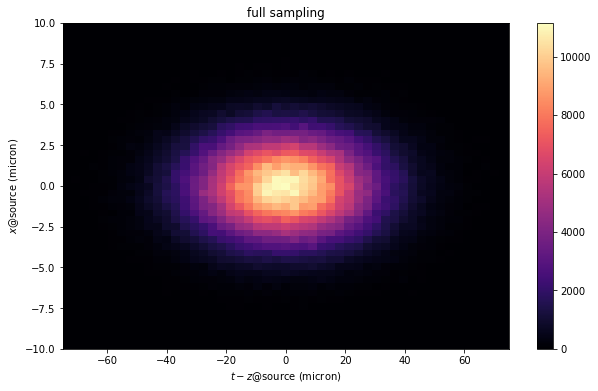

In [9]:
figure(figsize=(10,6))
bbins=(linspace(-75,75,50),linspace(-2*w0,2*w0,50))

subplot(111)
hist2d(X0-X3,X1,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$x@$source (micron)')
title(f'{sampling} sampling')



savefig(f'photon_source_length_{input_filename}_{mode}.pdf')


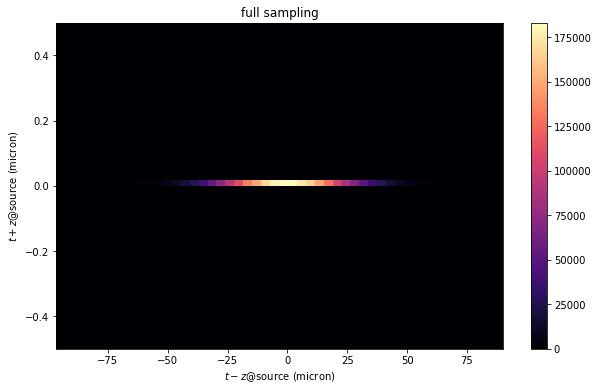

In [10]:
figure(figsize=(10,6))
bbins=(50,50)

subplot(111)
hist2d(X0-X3,X0+X3,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$t+z@$source (micron)')
title(f'{sampling} sampling')



savefig(f'photon_source_lightfront_{input_filename}_{mode}.pdf')


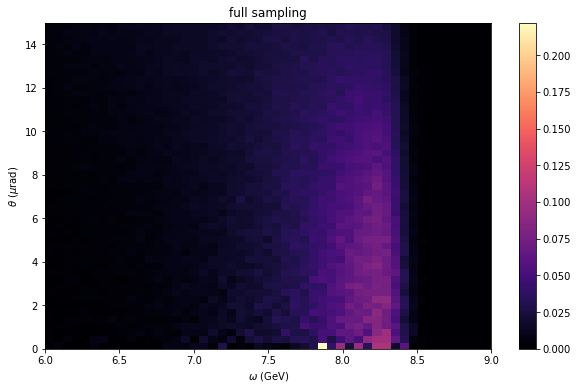

In [11]:
figure(figsize=(10,6))

bbins=(linspace(6,9,50),linspace(0,15,50))

subplot(111)
hist2d(K0/1e9,sqrt(K1**2+K2**2)/K3*1e6,bins=bbins,weights=W/sqrt(K1**2+K2**2),rasterized=True,cmap=cm.magma);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ ($\mu$rad)');
title(rf'{sampling} sampling')


savefig(f'photon_angular_spectrum_{input_filename}_{mode}.pdf')


In [12]:
# figure(figsize=(10,6))

# bbins=(linspace(6,9,50),linspace(0,50,50))

# subplot(111)
# hist2d(K0/1e9,sqrt(X1**2+X2**2),bins=bbins,weights=W/sqrt(X1**2+X2**2),rasterized=True,cmap=cm.magma);
# colorbar()
# xlabel(r'$\omega$ (GeV)')
# ylabel(r'$\theta$ ($\mu$rad)');
# title(rf'{sampling} sampling')


# savefig(f'photon_transverse_spectrum_{input_filename}_{mode}.pdf')


In [13]:
thetax=K1/K3
thetay=K2/K3

baseline = 7.5e6 

xoffset = thetax * baseline
yoffset = thetay * baseline

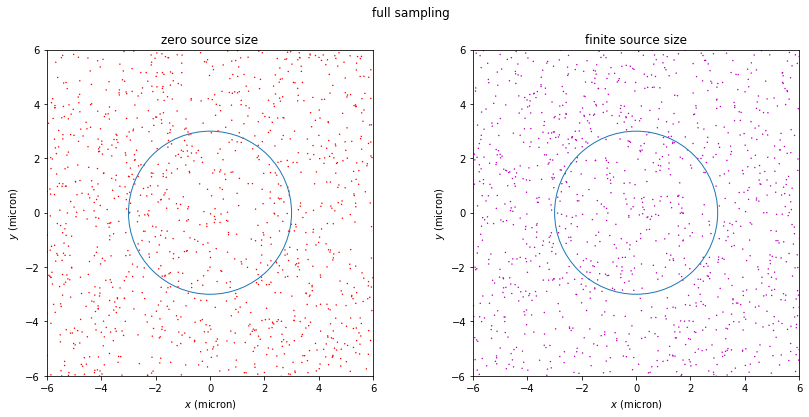

In [36]:
spotsize = 3 # micron


figure(figsize=(14,6))

ax1=subplot(121,aspect=1)
scatter(xoffset, yoffset, color='r',marker='.',lw=0,s=W);
xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('zero source size')


ax2=subplot(122,aspect=1)

# plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);
scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)

xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('finite source size')

ax1.add_patch(Circle((0,0),spotsize,color='C0',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='C0',fill=False))


suptitle(f'{sampling} sampling')

savefig(f'photons_at_focus_{input_filename}_{mode}.png',dpi=200)



In [37]:
selector1 = sqrt(xoffset**2+yoffset**2) < spotsize
selector2 = sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


print ( f'IP-laser spot size: {spotsize:.2f} micron')
print ( f'baseline          : {baseline/1e6:.2f} metres')
print ('-'*42)

print (f'photons in spot, {sampling} sampling:')
print (f'macrophoton weight               : {amax(W):.4g}')
print ( 'macrophotons, zero   source size :',sum( selector1 ) )
print ( 'macrophotons, finite source size :',sum( selector2 ) )
print ( 'photon weight, zero   source size:',sum(W[selector1 ] ) )
print ( 'photon weight, finite source size:',sum(W[selector2 ] ) )


IP-laser spot size: 3.00 micron
baseline          : 7.50 metres
------------------------------------------
photons in spot, full sampling:
macrophoton weight               : 8.9
macrophotons, zero   source size : 226
macrophotons, finite source size : 229
photon weight, zero   source size: 1928.1412022558234
photon weight, finite source size: 1955.367382900537


### Photon Spectrum at IP

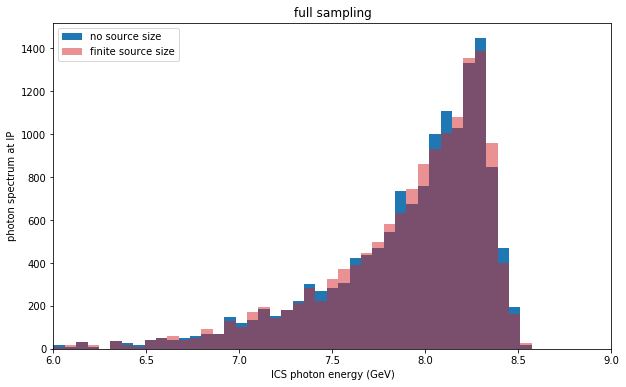

In [16]:
figure(figsize=(10,6))

subplot(111)
hist(K0[selector1]/1e9,bins=linspace(6,9,50),weights=W[selector1],alpha=1  ,fc='C0',label='no source size');
hist(K0[selector2]/1e9,bins=linspace(6,9,50),weights=W[selector2],alpha=0.5,fc='C3',label='finite source size'); 
xlim(6,9)
legend()
xlabel('ICS photon energy (GeV)')
ylabel('photon spectrum at IP')
title(rf'{sampling} sampling')

savefig(f'photon_spectrum_at_focus_{input_filename}_{mode}.pdf')


### Photon Weight Distribution at IP

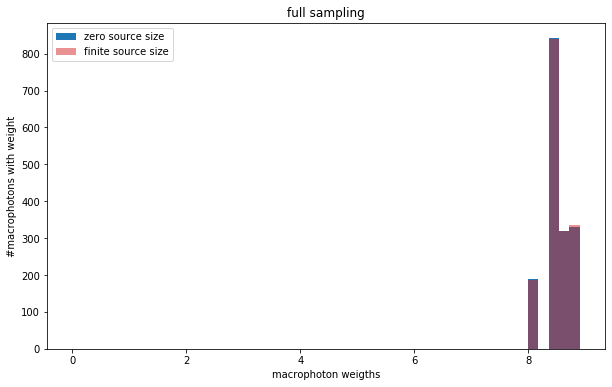

In [17]:
figure(figsize=(10,6))
base_weight = amax(W)
bbins = linspace(0,base_weight,50) 

hist( W[selector1],bins=bbins,label='zero source size'  ,fc='C0');
hist( W[selector2],bins=bbins,label='finite source size',fc='C3',alpha=0.5);


xlabel('macrophoton weigths')
ylabel('#macrophotons with weight')
title(rf'{sampling} sampling')
legend()
savefig(f'photon_weights_{input_filename}_{mode}.pdf')


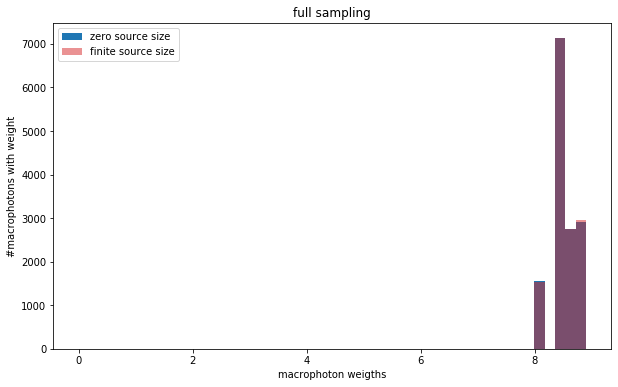

In [18]:
figure(figsize=(10,6))
base_weight = amax(W)
bbins = linspace(0,base_weight,50) 

hist( W[selector1],bins=bbins,weights=W[selector1],label='zero source size'  ,fc='C0',alpha=1.0);
hist( W[selector2],bins=bbins,weights=W[selector2],label='finite source size',fc='C3',alpha=0.5);

xlabel('macrophoton weigths')
ylabel('#macrophotons with weight')
title(rf'{sampling} sampling')
legend()
savefig(f'photon_weights2_{input_filename}_{mode}.pdf')


### Electrons

Text(0, 0.5, 'electron $p_y$ (MeV)')

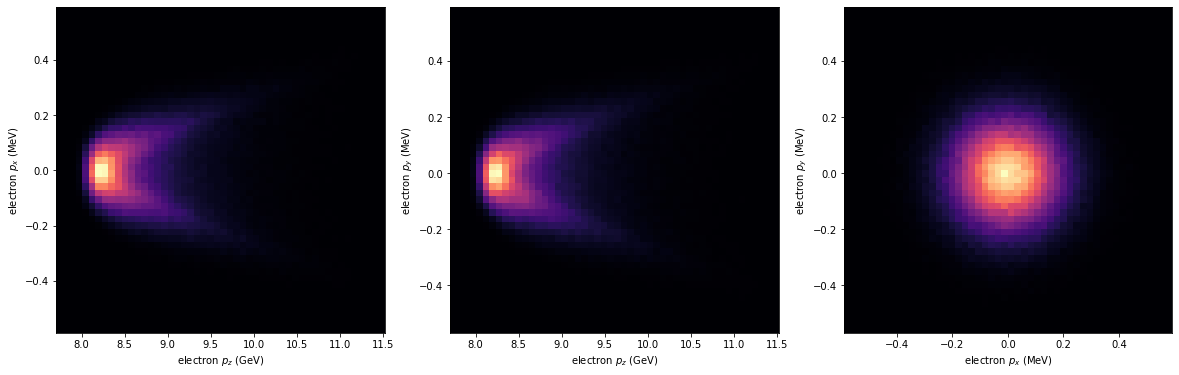

In [39]:
fig,ax=subplots(1,3,figsize=(20,6))
bbins=(50,50)

p0=ax[0].hist2d(P3/1e9,P1/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p0,ax=ax[0])

p1=ax[1].hist2d(P3/1e9,P2/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p1,ax=ax[1])

p2=ax[2].hist2d(P1/1e6,P2/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p2,ax=ax[2])


ax[0].set_xlabel(r'electron $p_z$ (GeV)')
ax[1].set_xlabel(r'electron $p_z$ (GeV)')
ax[2].set_xlabel(r'electron $p_x$ (MeV)')

ax[0].set_ylabel(r'electron $p_x$ (MeV)')
ax[1].set_ylabel(r'electron $p_y$ (MeV)')
ax[2].set_ylabel(r'electron $p_y$ (MeV)')


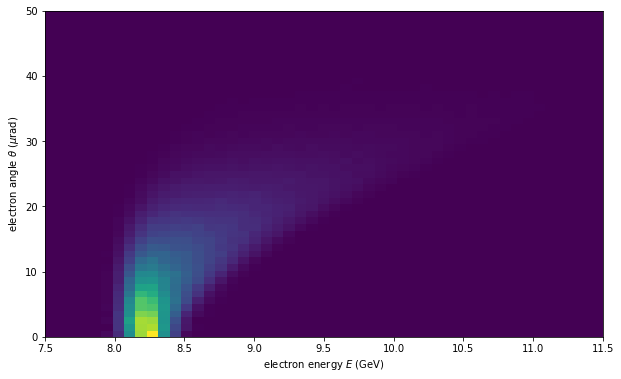

In [54]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(linspace(7.5,11.5,50),linspace(0,50,50))

fig,ax=subplots(1,1,figsize=(10,6))

hist2d( P0/1e9 , theta_e*1e6 , bins=bbins , weights=W/theta_e );

xlabel(r'electron energy $E$ (GeV)')
ylabel(r'electron angle $\theta$ ($\mu$rad)');

Text(0.5, 0, 'electron energy $E$ (GeV)')

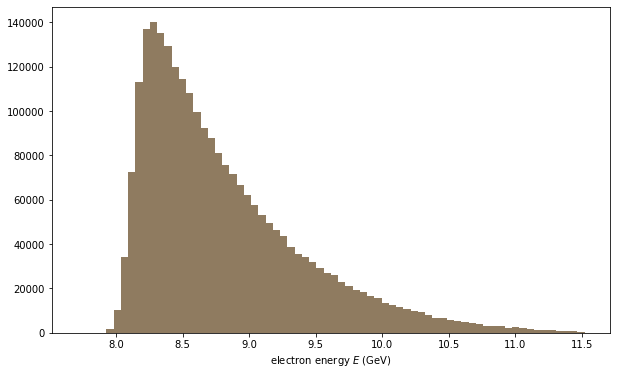

In [35]:
fig,ax=subplots(1,1,figsize=(10,6))
bbins=(50,50)

p0=ax.hist(P3/1e9,bins=70,weights=W);
p0=ax.hist(P0/1e9,bins=70,weights=W,alpha=0.5);
xlabel(r'electron energy $E$ (GeV)')

Text(0, 0.5, 'initial electron beam $p_x$')

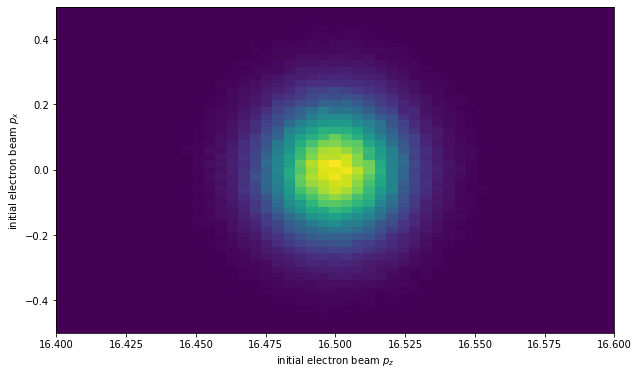

In [62]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(linspace(16.4,16.6,50),linspace(-0.5,0.5,50))

fig,ax=subplots(1,1,figsize=(10,6))

hist2d( (P3+K3)/1e9 , (P1+K1)/1e6 , bins=bbins );
xlabel(r'initial electron beam $p_z$')
ylabel(r'initial electron beam $p_x$')


